# Prepare the Environment

In [ ]:
!pip install --upgrade -r requirements.txt
!pip install -e ./src

In [4]:
#auto reload libraries
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import torch
from models.translation_models import AlignAndTranslate
from src.data_preprocessing import load_data
import yaml
from metrics.bleu import bleu_seq
import os 
import zipfile
import requests
import global_variables

In [6]:
device = global_variables.DEVICE
print(f"Using {device} device")
# Load YAML config file
with open("translation_config.yaml", "r") as config_file:
    config = yaml.safe_load(config_file)


Using cuda device


## General Configurations

In [7]:
#CONFIGS TO BE USED ALL OVER
# Define configuration for the encoder
config_encoder = dict(
    rnn_hidden_size=config["hidden_size"],
    rnn_num_layers=1,
    rnn_device=device,
    vocab_size=config["vocab_size_en"] + 1,
    rnn_type="LSTM",
    embedding_size=config["embedding_size"],
)

# Define configuration for the decoder
config_rnn_decoder = dict(
    input_size=config["hidden_size"] * 2 + config["embedding_size"],
    hidden_size=config["hidden_size"],
    num_layers=1,
    device=device,
    type="LSTM",
    bidirectional=False,
)
alignment_cfg = dict(
    input_size=config["hidden_size"] * 3,
    output_size=config["Tx"],
    device=device,
    dropout=0.3,
)
output_nn_cfg = dict(
    embedding_size=config["embedding_size"],
    max_out_units=config["max_out_units"],
    hidden_size=config["hidden_size"],
    vocab_size=config["vocab_size_fr"] + 1,
    device=device,
    dropout=0.3,
)
decoder_embedding_cfg = dict(
    embedding_size=config["embedding_size"],
    device=device,
)
config_decoder = dict(
    alignment=alignment_cfg,
    rnn=config_rnn_decoder,
    output_nn=output_nn_cfg,
    embedding=decoder_embedding_cfg,
    traditional = config["encoder_decoder"],
)



# Testing Part

In [8]:
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download&confirm=1"

    session = requests.Session()

    response = session.get(URL, params={"id": id}, stream=True)
    token = get_confirm_token(response)

    if token:
        params = {"id": id, "confirm": token}
        response = session.get(URL, params=params, stream=True)

    save_response_content(response, destination)


def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith("download_warning"):
            return value

    return None


def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)
file_id = "1B4JbkCN2B2Opnh4ovDETRTq1FsVpDi6n"
destination = "d.zip"
if not os.path.exists("./dummy"):
    print(f"dowload {file_id} to {destination}")
    if not os.path.exists(destination):
        download_file_from_google_drive(file_id, destination)
    with zipfile.ZipFile(destination, "r") as zip_ref:
        zip_ref.extractall(".")

In [9]:
#Needed for evaluation to extract the vocab with the right size
# Load data
(
    (train_data, train_dataloader),
    (val_data, val_dataloader),
    (english_vocab, french_vocab),
) = load_data(
    train_len=config['train_len'],
    val_len=config['val_len'],
    kx=config['vocab_size_en'],
    ky=config['vocab_size_fr'],
    Tx=config['Tx'],
    Ty=config['Ty'],
    batch_size=config['batch_size'],
    vocab_source=config['vocab_source'],
    mp=config["multiprocessing"],
    only_vocab = True
)

Loading and preprocessing data...
Extracting word frequency...
Done extraction
Some samples from the training dataset from the loaded data
Some samples from the validation dataset from the loaded data
Data loading and preprocessing complete.


In [10]:

# Define training configuration
testing_cfg = dict(
    device=device,
    output_vocab_size=len(french_vocab) + 1,
    english_vocab=english_vocab,
    french_vocab=french_vocab,
    epochs=config["epochs"],
    load_last_model=config["load_last_model"],
    beam_search = True,
    Tx = config["Tx"],
    Ty = config["Ty"],
)

# Define the whole configuration
translator_cfg = dict(encoder=config_encoder, decoder=config_decoder, training=testing_cfg)

In [11]:
english_phrases = [
    "it should be noted that the marine environment is the least known of environments .",
    "The agreement on the European Economic Area was signed in August 1992 .",
    "Destruction of the equipment means that Syria can no longer produce new chemical weapons .",
    "\" This will change my future with my family , \" the man said .",
]
french_translation = [
    "il faut noter que l'environnement marin est le moins connu des environnements .",
    "L'accord sur l'Espace économique européen a été signé en août 1992 .",
    "La destruction de l'équipement signifie que la Syrie ne peut plus produire de nouvelles armes chimiques .",
    "« Cela changera mon avenir avec ma famille », a déclaré l'homme .",
]
to_translate = []
for en, fr in zip(english_phrases, french_translation):
    to_translate.append(dict(translation=dict(en=en, fr=fr)))

### a) RNNSearch

In [12]:
translator_cfg["decoder"]["traditional"] = False
translator_cfg["decoder"]["rnn"]["type"] = "LSTM"
translator_cfg["encoder"]["rnn_type"] = "LSTM"
translator_cfg["decoder"]["alignment"]["output_size"] = 30
translator_cfg["training"]["Tx"] = 30
translator_cfg["training"]["Ty"] = 30
# Create the model
RNNSearchmodel = AlignAndTranslate(**translator_cfg).to(device)
RNNSearchmodel.load_model('./dummy/rnn-search30/checkpoint.pth')

Model loaded from ./dummy/rnn-search30/checkpoint.pth


In [13]:
translations, alignments = RNNSearchmodel.translate_sentence(to_translate)


In [14]:
bleu_scores = []
bleu_scores.append(
    bleu_seq(translations[1], translations[2], n=3)
)
for i in range(len(translations[0])):
    print("Input ")
    print("\t",translations[0][i])
    print("Expected Output")
    print("\t",translations[2][i])
    print("Predicted Output")
    print("\t",translations[1][i])
    print("\t",round(float(bleu_scores[0][i])*100,2), " %")
    print()

Input 
	 it should be noted that the marine environment is the least known of environments.
Expected Output
	 il faut noter que environnement marin est le moins connu des environnements.
Predicted Output
	 il faut de noter que le milieu marin est le moins moins environnements.
	 20.0  %

Input 
	 the agreement on the european economic area was signed in august 1992.
Expected Output
	 accord sur espace économique européen a été signé en août 1992.
Predicted Output
	 l accord sur la accord économique européenne a été signé août en août..
	 11.11  %

Input 
	 destruction of the equipment means that syria can no longer produce new chemical weapons.
Expected Output
	 la destruction de équipement signifie que la syrie ne peut plus produire de nouvelles armes chimiques.
Predicted Output
	 la destruction des équipements équipement que la syrie ne peut produire plus produire de produire chimiques.
	 28.57  %

Input 
	 this will change my future with my family the man said.
Expected Output
	 « c

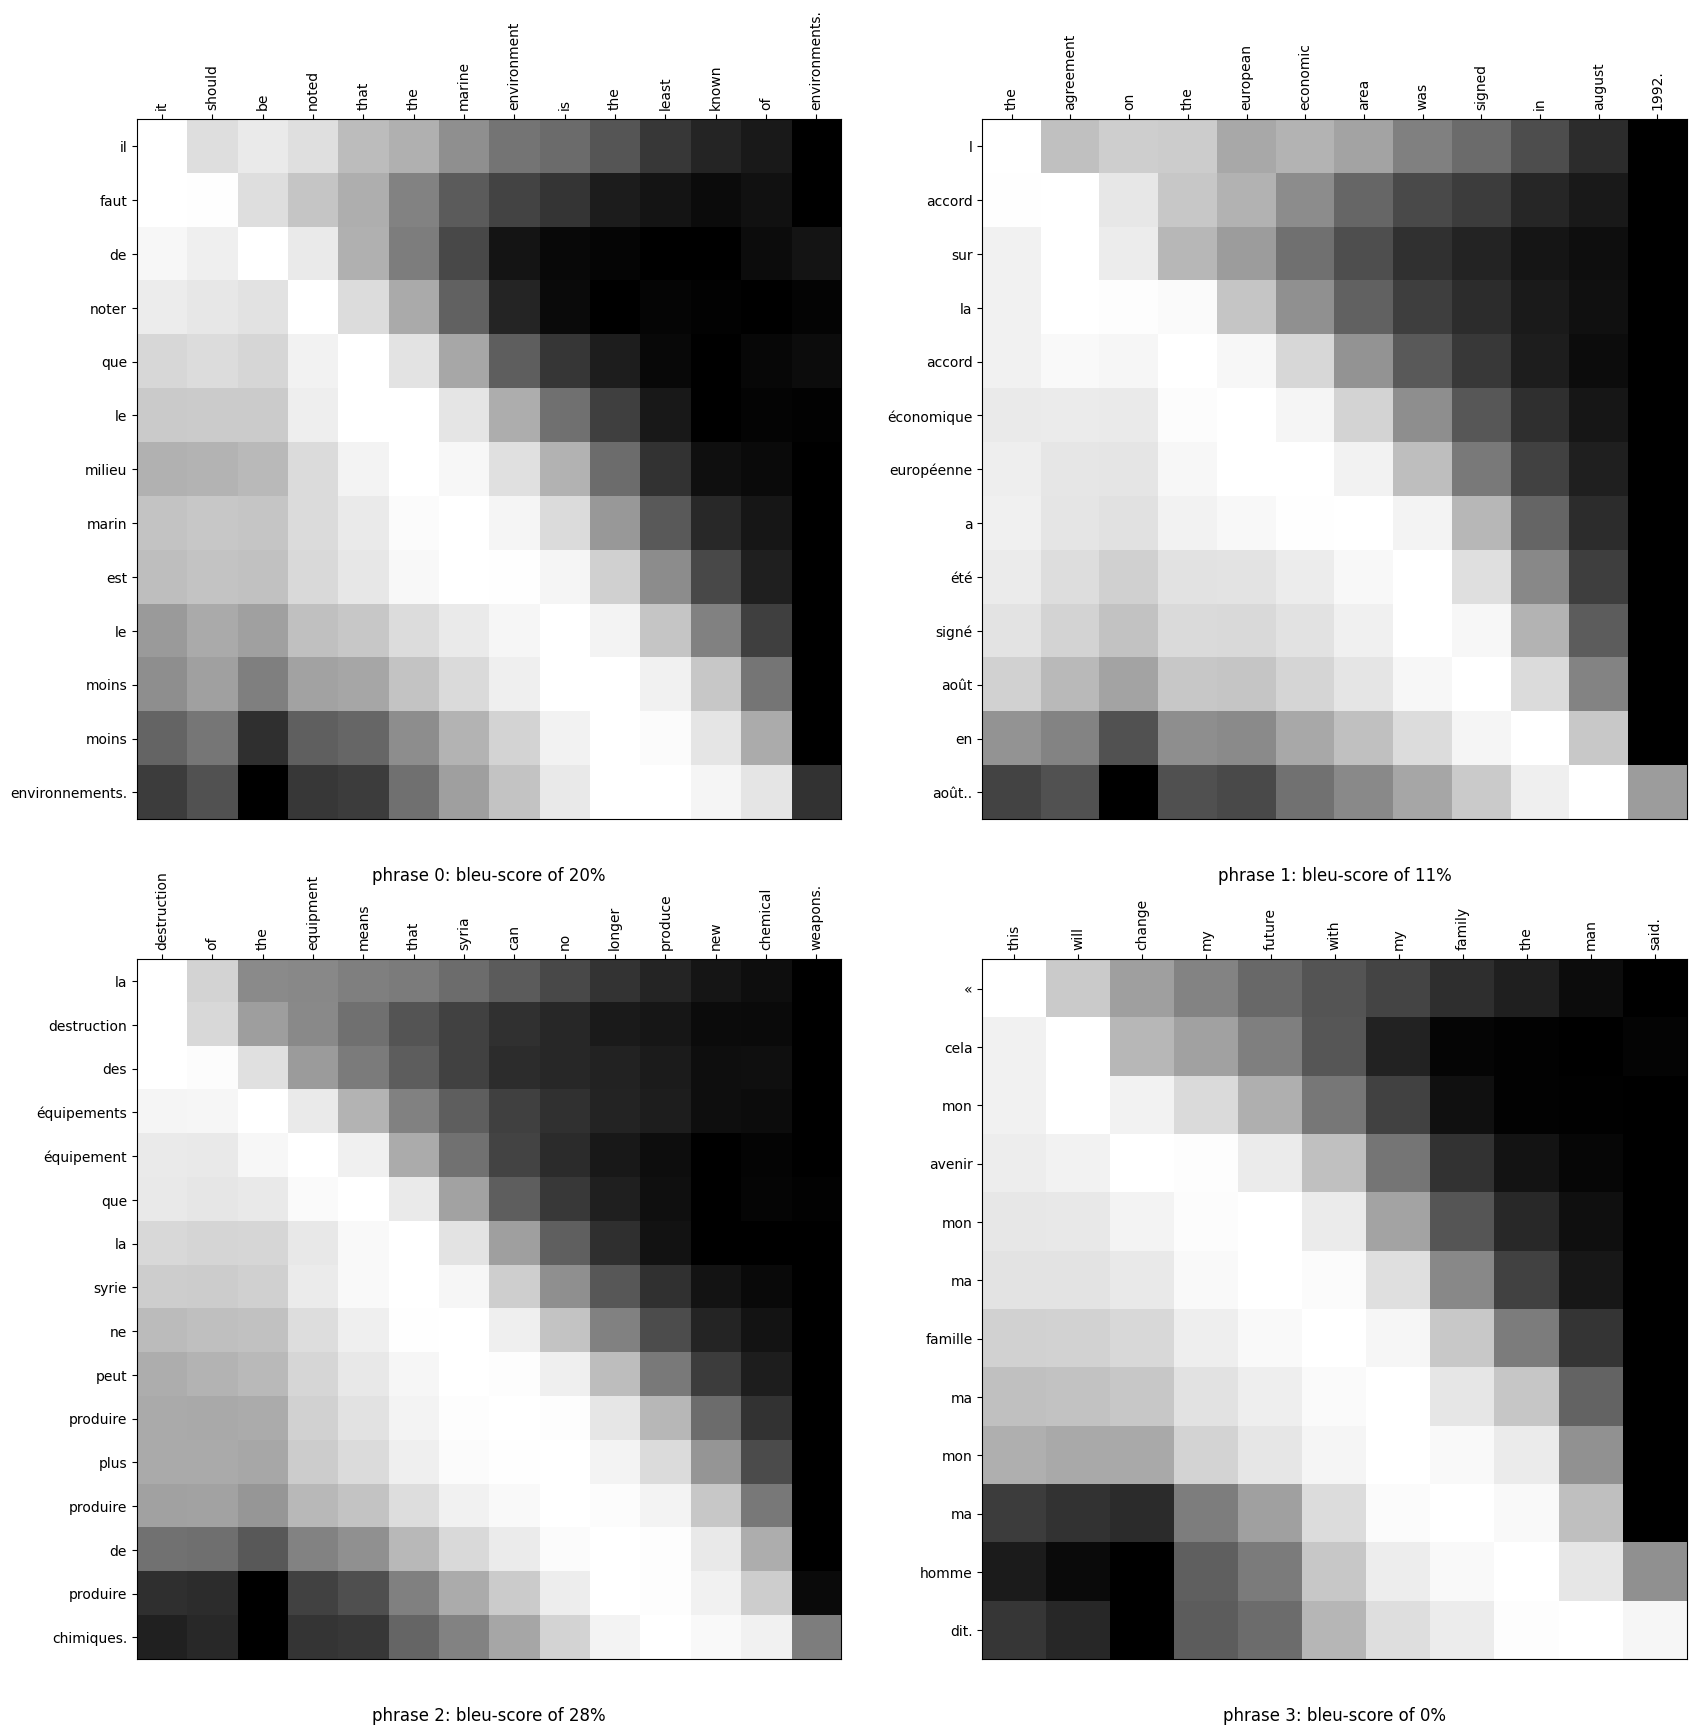

In [15]:
RNNSearchmodel.plot_attention(translations[0], translations[1], alignments, bleu_scores[0], path = './dummy/enco-deco30/attention.png')

### b) RNNEncDec

In [13]:
translator_cfg["decoder"]["traditional"] = True
translator_cfg["decoder"]["rnn"]["type"] = "GRU"
translator_cfg["encoder"]["rnn_type"] = "GRU"
translator_cfg["decoder"]["alignment"]["output_size"] = 20
translator_cfg["training"]["Tx"] = 20
translator_cfg["training"]["Ty"] = 20
# Create the model
RNNEncoDecomodel = AlignAndTranslate(**translator_cfg).to(device)
RNNEncoDecomodel.load_model('./dummy/enco-deco20/checkpoint.pth')

translations, alignments = RNNEncoDecomodel.translate_sentence(to_translate)

bleu_scores = []
bleu_scores.append(
    bleu_seq(translations[1], translations[2], n=3)
)


Model loaded from ./dummy/enco-deco20/checkpoint.pth


In [14]:
for i in range(len(translations[0])):
    print("Input ")
    print("\t",translations[0][i])
    print("Expected Output")
    print("\t",translations[2][i])
    print("Predicted Output")
    print("\t",translations[1][i])
    print("Bleu score")
    print("\t",round(float(bleu_scores[0][i])*100,2), " %")
    print()

Input 
	 it should be noted that the marine environment is the least known of environments.
Expected Output
	 il faut noter que environnement marin est le moins connu des environnements.
Predicted Output
	 il faut de noter que le milieu marin est milieu moins le environnements milieux environnements.
Bleu score
	 0.0  %

Input 
	 the agreement on the european economic area was signed in august 1992.
Expected Output
	 accord sur espace économique européen a été signé en août 1992.
Predicted Output
	 l accord sur la accord économique de a été signée en août 1992.
Bleu score
	 11.11  %

Input 
	 destruction of the equipment means that syria can no longer produce new chemical weapons.
Expected Output
	 la destruction de équipement signifie que la syrie ne peut plus produire de nouvelles armes chimiques.
Predicted Output
	 la destruction de matériel signifie que la ne syrie ne plus produire plus armes.. chimiques
Bleu score
	 14.29  %

Input 
	 this will change my future with my family the 

# Training Part
do not run these cells if you are not training the model

In [ ]:
#Needed for evaluation to extract the vocab with the right size
# Load data
(
    (train_data, train_dataloader),
    (val_data, val_dataloader),
    (english_vocab, french_vocab),
) = load_data(
    train_len=config['train_len'],
    val_len=config['val_len'],
    kx=config['vocab_size_en'],
    ky=config['vocab_size_fr'],
    Tx=config['Tx'],
    Ty=config['Ty'],
    batch_size=config['batch_size'],
    vocab_source=config['vocab_source'],
    mp=config["multiprocessing"],
    only_vocab = False
)

In [ ]:

# Define training configuration
training_cfg = dict(
    device=device,
    output_vocab_size=len(french_vocab) + 1,
    english_vocab=english_vocab,
    french_vocab=french_vocab,
    epochs=config["epochs"],
    load_last_model=config["load_last_model"],
    beam_search = True,
    Tx = config["Tx"],
    Ty = config["Ty"],
)

# Define the whole configuration
translator_cfg = dict(encoder=config_encoder, decoder=config_decoder, training=training_cfg)

### a) RNNSearch

In [ ]:
translator_cfg["decoder"]["traditional"] = False
# Create the model
RNNSearchmodel = AlignAndTranslate(**translator_cfg).to(device)
RNNSearchmodel.train(train_dataloader, val_dataloader)

### b) RNNEncDec

In [ ]:
translator_cfg["decoder"]["traditional"] = True
# Create the model
RNNSearchmodel = AlignAndTranslate(**translator_cfg).to(device)
RNNSearchmodel.train(train_dataloader, val_dataloader)
